## GA

In [42]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

[11 24 26 25 23 22 33 32 20 16 17 19 21 18 15 13 14 12 10  9  4  0  1  2
  3  8  7  5  6 28 29 31 30 27]
best_distance: 16026.0 time cost: 1.9048073291778564


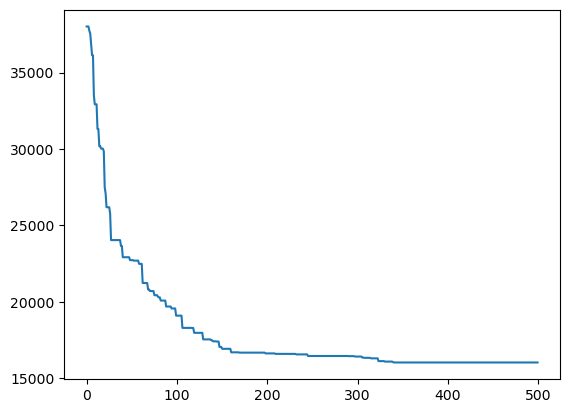

In [61]:
df = pd.read_csv('distance_matrix.csv')
num_points = 34
distance_matrix = np.round(df.values)
def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


# %% do GA

from sko.GA import GA_TSP

ga_tsp = GA_TSP(func=cal_total_distance, n_dim=num_points, size_pop=50, max_iter=500, prob_mut=1)
time_start = time.time()
best_points, best_distance = ga_tsp.run()
time_end = time.time()
print(best_points)
print('best_distance:', best_distance[0], 'time cost:', time_end - time_start)
fig, ax = plt.subplots()
ax.plot(ga_tsp.generation_best_Y)
plt.show()

## OR-tools

In [3]:
"""Simple Travelling Salesperson Problem (TSP) between cities."""
import numpy as np
from scipy import spatial
import time

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix.tolist()
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    time_start = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    time_end = time.time()
    print(f"time: {time_end - time_start}")

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)


if __name__ == "__main__":
    main()

time: 0.0010027885437011719
Objective: 0 miles
Route for vehicle 0:
 0 -> 33 -> 32 -> 31 -> 30 -> 29 -> 28 -> 27 -> 26 -> 25 -> 24 -> 23 -> 22 -> 21 -> 20 -> 19 -> 18 -> 17 -> 16 -> 15 -> 14 -> 13 -> 12 -> 11 -> 10 -> 9 -> 8 -> 7 -> 6 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0



In [62]:
routine = pd.DataFrame(columns=["city","lat", "lon"])
df_start = pd.read_csv('cityinfo.csv')

for i in range(34):
    routine.loc[i] = df_start.loc[best_points[i]]

import folium
import pandas as pd

# 创建一个中心位于北京的地图
m = folium.Map(location=[39.9042, 116.4074], zoom_start=5)

# 假设我们有一个包含城市坐标的数据集
cities_data = routine

# 添加城市标记
for index, row in cities_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['city'],
        icon=folium.Icon(color='red')
    ).add_to(m)

# 连接城市
temp = cities_data[['lat', 'lon']].values.tolist()
locations = np.vstack((temp, temp[0]))
folium.PolyLine(locations, color="blue", weight=2.5, opacity=1).add_to(m)

m.save('routine_GA.html')